In [4]:
#import package
using CSV, DataFrames
using Optim
using Plots
include("../src/ARCHModels.jl")
using .ARCHModels

In [5]:
# load data
tickers = ["SPY","KO","AAPL","TSLA","JNJ","CVX"]
ticker = tickers[1] # Choose ticker 
filename = ticker*"_RMs.csv"#
readpath = dirname(pwd())*"\\src\\data\\"*filename
df = DataFrame(CSV.File(readpath,header = 1))

,Column1,RV_15s,RV_2min,RV_5min,RV_10min,RV_15min,DR
,Date,Float64,Float64,Float64,Float64,Float64,Float64
1,2015-01-02,5.3e-5,6.6e-5,5.98e-5,5.92e-5,6.4e-5,0.0131125
2,2015-01-05,9.54e-5,0.000108023,8.86e-5,0.000101305,0.000108972,0.0148874
3,2015-01-06,0.000109731,9.35e-5,0.000119639,0.000137793,0.000144754,0.0192498
4,2015-01-07,0.000152944,0.000123204,0.000117869,0.00011723,0.000134762,0.009118
5,2015-01-08,9.02e-5,0.000103325,0.000109735,0.000119771,0.000150087,0.0105816
6,2015-01-09,6.86e-5,6.99e-5,6.41e-5,5.73e-5,9.37e-5,0.0141248
7,2015-01-12,6.93e-5,7.6e-5,6.95e-5,7.46e-5,7.07e-5,0.0130869
8,2015-01-13,0.000148913,0.000180678,0.000257363,0.000256669,0.000301285,0.0244347
9,2015-01-14,0.000254339,0.00023792,0.00019501,0.000210565,0.000183436,0.0126606


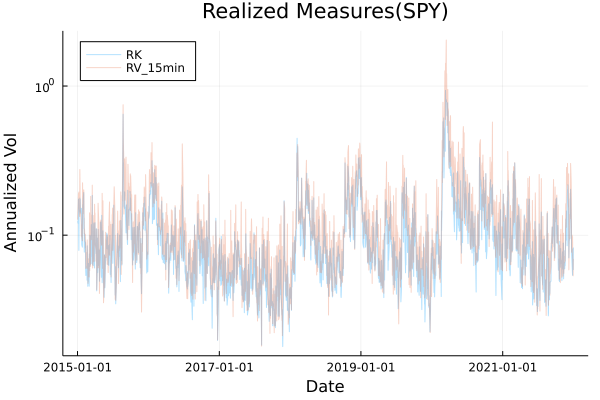

In [15]:
#Plot realized measures
plot(df[:,1],sqrt.(252*df[:,"RK"]),title="Realized Measures("*ticker*")",yaxis=:log,alpha=0.3,label="RK",ylabel="Annualized Vol",legend=:topleft,xlabel="Date")
plot!(df[:,1],sqrt.(252*df[:,"RV_15min"]),alpha=0.3,label="RV_15min")


In [11]:
#Model estimation

rms = ["RV_15s","RV_2min","RV_5min","RV_10min","RV_15min","DR","RK"]


# set insample size
N₁ = 1000

# daily return
c2c_r = diff(log.(df.close))
rt = c2c_r

#Out-of-sample unbiased daily variance 
σt2 = c2c_r[N₁+1:end].^2 .+0.00001 # 1 day squared return
#σt2 = df[N₁+2:end,"RV_15min"] # 15min RV
rt_N₁ = rt[1:N₁]

QLIKE = Dict()
fitted_coefs = Dict()
fitted_coefs["Parameter"] = ["ω","β","τ₁","τ₂","γ","ξ","δ₁","δ₂"]

for rm0 in rms
    rm = df[2:end,rm0]
    xt = rm
    xt_N₁ = rm[1:N₁]

    spec = RealGARCH{1,1}(zeros(8)) # RealGARCH{p,q} = pRealGARCH{p,q₁,q₂,S} where q₁=q₂ 

    am = UnivariateARCHXModel(spec,rt_N₁,xt_N₁)

    fitted_am = fit(am);
    fitted_coefs[rm0] = fitted_am.spec.coefs

    spec = RealGARCH{1,1}(fitted_coefs[rm0])
    am = UnivariateARCHXModel(spec,rt,xt)

    ht_realgarch_os = (volatilities(am).^2)[N₁+1:end]
    
    QLIKE[rm0] = [qlike(σt2,ht_realgarch_os)]
end


Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0     7.130907e+06              NaN
 * time: 0.0


   500    -7.247267e+03     1.434565e+00


 * time: 0.04800009727478027
  1000    -7.421450e+03     2.189220e-02
 * time: 0.09599995613098145


Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0     7.130907e+06              NaN
 * time: 0.0


   500    -7.219127e+03     2.913523e+00
 * time: 0.05200004577636719


  1000    -7.339497e+03     5.059898e-03
 * time: 0.10000014305114746


Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0     7.130907e+06              NaN
 * time: 0.0


   500    -7.096879e+03     6.512220e-01
 * time: 0.051999807357788086


  1000    -7.226751e+03     2.313768e-01
 * time: 0.10099983215332031
Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0     7.130907e+06              NaN
 * time: 0.0


   500    -7.054664e+03     4.396285e-01


 * time: 0.05799984931945801
  1000    -7.184543e+03     3.355837e-01


 * time: 0.10899996757507324
Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0     7.130907e+06              NaN
 * time: 0.0


   500    -6.970960e+03     7.885560e+00
 * time: 0.05500006675720215


  1000    -7.094378e+03     2.598798e-02
 * time: 0.10600018501281738


Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0     7.130906e+06              NaN


 * time: 0.0
   500    -5.928716e+03     5.883745e-02
 * time: 0.0710000991821289


  1000    -6.093801e+03     1.317179e+00
 * time: 0.13000011444091797


  1500    -6.417563e+03     6.836218e-02


 * time: 0.1919999122619629
Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0     7.130907e+06              NaN
 * time: 0.0


   500    -6.990557e+03     2.573555e+00
 * time: 0.05500006675720215


  1000    -7.452605e+03     1.980602e+00
 * time: 0.10599994659423828


In [12]:
#QLIKE table
QLIKE_table = DataFrame(QLIKE)[:,rms]


,RV_15s,RV_2min,RV_5min,RV_10min,RV_15min,DR,RK
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.503376,0.513691,0.506016,0.513716,0.529804,1.82644,0.471411


In [13]:
#Relative QLIKE table (QLIKE of RealGARCH normalized to 1)
relative_QLIKE_table = QLIKE_table ./ QLIKE_table[1,"RK"]

,RV_15s,RV_2min,RV_5min,RV_10min,RV_15min,DR,RK
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.06781,1.08969,1.07341,1.08974,1.12387,3.87441,1.0


In [14]:
coef_tables = DataFrame(fitted_coefs)
coef_tables = coef_tables[:,["Parameter","RV_15s","RV_2min","RV_5min","RV_10min","RV_15min","DR","RK"]]
show(coef_tables,allcols=true)

8×8 DataFrame
 Row │ Parameter  RV_15s      RV_2min     RV_5min     RV_10min    RV_15min    DR         RK         
     │ String     Float64     Float64     Float64     Float64     Float64     Float64    Float64    
─────┼──────────────────────────────────────────────────────────────────────────────────────────────
   1 │ ω          -0.549715   -0.584287   -0.596666   -0.582067   -0.574851   -0.325234  -0.60195
   2 │ β           0.942534    0.938932    0.937656    0.939173    0.939889    1.00796    0.93714
   3 │ τ₁         -0.168858   -0.173123   -0.174704   -0.16679    -0.169938   -0.920423  -0.195039
   4 │ τ₂          0.0690015   0.0750148   0.0742294   0.0763139   0.0765487  -0.432356   0.0640526
   5 │ γ           0.311321    0.298082    0.298695    0.269394    0.253395    0.3736     0.386044
   6 │ ξ          -0.267612   -0.296003   -0.325919   -0.380321   -0.394301    1.88652   -0.7508
   7 │ δ₁         -0.108909   -0.113645   -0.104938   -0.0875403  -0.0748918  -1.00059   -0.